# Phase code solution summary figure
The purpose of this notebook is to compile all of our findings into a single six figure panel.

## Imports

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import combinations_with_replacement

import jax
import jax.numpy as jnp
from jax import random

import scipy.signal
import scipy.stats

from ctrnn_jax.model import CTRNNCell
from ctrnn_jax.training import ModelParameters, create_train_state
from ctrnn_jax.pca import compute_pca

from emergence_phase_codes.model import initialize_ctrnn
from emergence_phase_codes.task import ModuloNArithmetic
from emergence_phase_codes.pca import add_data

from emergence_phase_codes.animations.output import OutputAnimator
from emergence_phase_codes.animations.pca import PCATrajectoryAnimator, PCAPopulationAnimator
from emergence_phase_codes.animations.utils import interpolate_colors

In [2]:
key = random.PRNGKey(69)

## Configure parameters

In [3]:
# Modulo3Arithmetic task parameters
BATCH_SIZE_M3A = 16

MOD = 3
CONGRUENT_NUMBER = 0
TIME_LENGTH = 50
NUM_TRIALS = 2500

TRIALS_PER_POS = 100
TRIALS_PER_NEG = 50

PULSE_CONFIG = {
    "num_pulses": 3,
    "pulse_window": 35,
    "pulse_buffer": 5,
    "pulse_gap": 5,
    "pulse_amplitude": 5,
}

INIT_ARRAY_M3A = jnp.ones([BATCH_SIZE_M3A, TIME_LENGTH, MOD])

In [4]:
# Configure model parameters
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 1
ALPHA = 1.0
NOISE_SCALAR = 0.00

## Initialize MNA task

In [5]:
# Initialize task
key, task_key = random.split(key, num=2)
task = ModuloNArithmetic(
    task_key, 
    MOD,
    congruent_number=CONGRUENT_NUMBER,
    time_length=TIME_LENGTH,
    num_trials=NUM_TRIALS,
    pulse_config=PULSE_CONFIG,
)
task.return_number_of_sequences()

27

In [6]:
# Initialize tensorflow dataset
tf_dataset_train = task.generate_tf_dataset(BATCH_SIZE_M3A)
len(task.dataset)

2500

## Load CT-RNN

In [7]:
# Initialize model
ctrnn = initialize_ctrnn(
    hidden_features=HIDDEN_FEATURES,
    output_features=OUTPUT_FEATURES,
    alpha=ALPHA,
    noise_const=NOISE_SCALAR,
)

In [8]:
# Initialize train state
key, train_state_key = random.split(key, num=2)
train_state = create_train_state(
    train_state_key, 
    ctrnn, 
     1E-4, 
    INIT_ARRAY_M3A,
)

In [9]:
# Load parameters
params = ModelParameters(train_state)
params.deserialize("../data/phase_code_solution_m3a_task.bin")

## Compute PCA and null rates

In [10]:
# Compute PCA
key, pca_key = random.split(key, num=2)
model_behavior, pca = compute_pca(
    pca_key,
    train_state,
    params.params,
    tf_dataset_train,
    3,
)

In [11]:
# Compute null rates
key, test_key = random.split(key, num=2)
output_null, rates_null = train_state.apply_fn(
    params.params, 
    jnp.zeros((1, TIME_LENGTH, MOD)), 
    rngs={"noise_stream": test_key}
)
rates_pc_null = pca.transform(rates_null[0,:,:])

## Figure from `phase_code_solution_m3a_task.ipynb`

In [12]:
# Make congruent example input
congruent_example_input, _ = task.create_trial_with_indices(
    jnp.array([2, 0, 1,]),
    jnp.array([10, 20, 30]),
)
congruent_example_input = congruent_example_input[None, :, :]

# Input congruent example into CT-RNN
key, congruent_key = random.split(key, num=2)
output_congruent, rates_congruent = train_state.apply_fn(
    params.params, 
    congruent_example_input, 
    rngs={"noise_stream": congruent_key}
)
rates_pc_congruent = pca.transform(rates_congruent[0,:,:])

# Add input, rates, and output to model_behavior
model_behavior= add_data(
    model_behavior, 
    pca, 
    congruent_example_input, 
    rates_congruent, 
    output_congruent,
)

In [13]:
# Make incongruent example input
incongruent_example_input, _ = task.create_trial_with_indices(
    jnp.array([0, 0, 2,]),
    jnp.array([15, 25, 35]),
)
incongruent_example_input = incongruent_example_input[None, :, :]

# Input congruent example into CT-RNN
key, incongruent_key = random.split(key, num=2)
output_incongruent, rates_incongruent = train_state.apply_fn(
    params.params, 
    incongruent_example_input, 
    rngs={"noise_stream": incongruent_key}
)
rates_pc_incongruent = pca.transform(rates_incongruent[0,:,:])

# Add input, rates, and output to model_behavior
model_behavior= add_data(
    model_behavior, 
    pca, 
    incongruent_example_input, 
    rates_incongruent, 
    output_incongruent,
)

In [14]:
output_congruent_dict = {-2: output_congruent[0,:,0]}
output_incongruent_dict = {-1: output_incongruent[0,:,0]}

blue_gradient = interpolate_colors("#7f7f7f", "#1f77b4", n_steps=TIME_LENGTH)
orange_gradient = interpolate_colors("#7f7f7f", "#ff7f0e", n_steps=TIME_LENGTH)

trajectory_indices = [-2, -1]
trajectory_colors = {
    -2: blue_gradient, 
    -1: orange_gradient,
}
classification_colors = {
    (1,): 'tab:blue', 
    (-1,): 'tab:orange',
}

In [15]:
# Define colors for integer stimuli
stimulus_colors = {0: "tab:green", 1: "tab:red", 2: "tab:purple"}

# Decode integer sequences for example trials
decoded_congruent = task.decode_integer_inputs(congruent_example_input[0,:,:],)
decoded_incongruent = task.decode_integer_inputs(incongruent_example_input[0,:,:],)

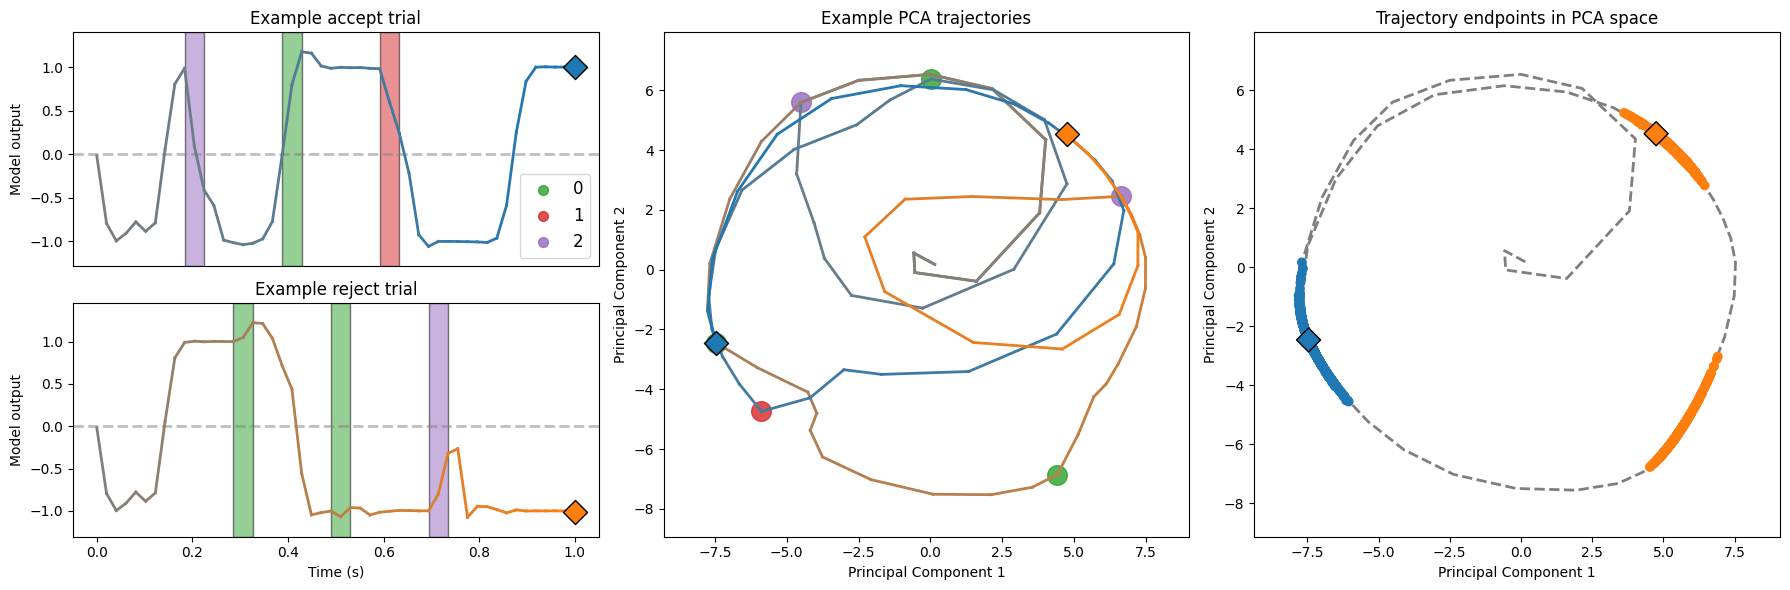

In [16]:
# Create the Figure
fig_anim = plt.figure(figsize=(18, 6))
gs = GridSpec(2, 3)

# Panel 1
ax_1 = fig_anim.add_subplot(gs[0, 0])
animator_1 = OutputAnimator(
    ax_1, output_congruent_dict, trajectory_colors,
    title='Example accept trial', stimulus_colors=stimulus_colors,
)
animator_1.color_integer_bars(decoded_congruent,)
animator_1.add_stimulus_legend()
ax_1.set_xticks([])
ax_1.set_xlabel('')
animator_1.figure()

# Panel 2
ax_2 = fig_anim.add_subplot(gs[1, 0,])
animator_2 = OutputAnimator(
    ax_2, output_incongruent_dict, trajectory_colors,
    title='Example reject trial', stimulus_colors=stimulus_colors,
)
animator_2.color_integer_bars(decoded_incongruent,)
animator_2.figure()

# Panel 3
ax_3 = fig_anim.add_subplot(gs[:, 1])
animator_3 = PCATrajectoryAnimator(
    ax_3, model_behavior, 1, 2, 
    trajectory_indices, trajectory_colors, 
    'Example PCA trajectories', stimulus_colors=stimulus_colors,
)
animator_3.color_integer_points(-2, decoded_congruent,)
animator_3.color_integer_points(-1, decoded_incongruent,)
animator_3.figure()

# Panel 4
ax_4 = fig_anim.add_subplot(gs[:, 2,])
animator_4 = PCAPopulationAnimator(
    ax_4, model_behavior, 1, 2, classification_colors,
    null_trajectory=rates_pc_null, highlight_indices=trajectory_indices,
    title='Trajectory endpoints in PCA space',
)
animator_4.figure()

plt.tight_layout()
plt.show()

## Phase differences over time

In [17]:
def compute_phase(pc_trajectory):
    return jnp.arctan2(pc_trajectory[:, 1], pc_trajectory[:, 0])

def compute_wrapped_phase_diff(traj_phase, ref_phase):
    return (traj_phase - ref_phase + jnp.pi) % (2 * jnp.pi) - jnp.pi

In [18]:
phase_null = compute_phase(rates_pc_null)
phase_congruent = compute_phase(rates_pc_congruent)
phase_incongruent = compute_phase(rates_pc_incongruent)

In [19]:
diff_congruent = compute_wrapped_phase_diff(phase_congruent, phase_null)
diff_incongruent = compute_wrapped_phase_diff(phase_incongruent, phase_null)

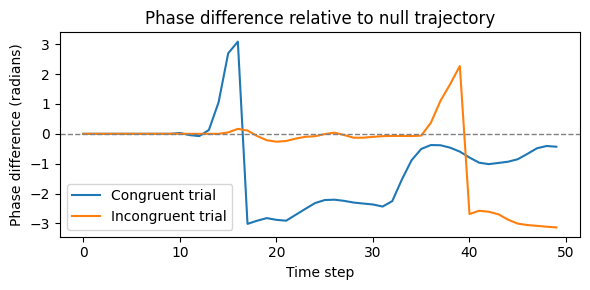

In [20]:
plt.figure(figsize=(6, 3))
plt.plot(diff_congruent, label="Congruent trial", color='tab:blue')
plt.plot(diff_incongruent, label="Incongruent trial", color='tab:orange')
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.ylabel("Phase difference (radians)")
plt.xlabel("Time step")
plt.title("Phase difference relative to null trajectory")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
phase_diff_congruent_dict = {-2: diff_congruent}
phase_diff_incongruent_dict = {-1: diff_incongruent}

## Load phase response curves

In [22]:
prc_tensor = jnp.load('../data/prc_tensor.npy',)
prc_tensor.shape

(3, 32, 32)

In [23]:
pulse_phase = jnp.load('../data/pulse_phase.npy',)

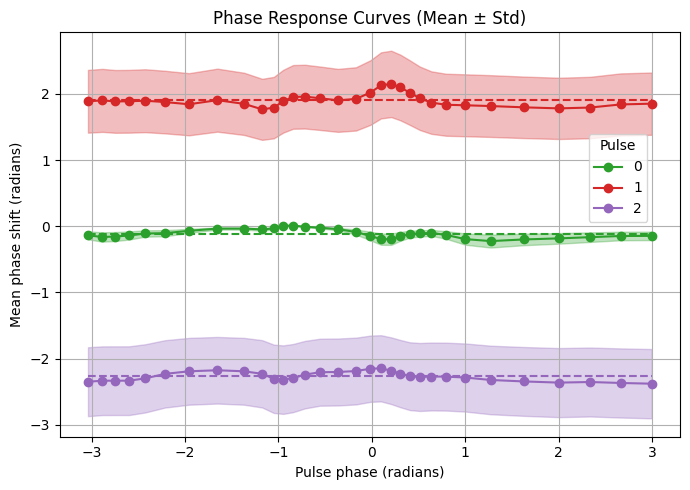

In [24]:
# Compute mean and std
mean_prc = prc_tensor.mean(axis=2)
std_prc = prc_tensor.std(axis=2)

# Sort by pulse_phase
sort_idx = jnp.argsort(pulse_phase)
pulse_phase_sorted = pulse_phase[sort_idx]
mean_prc_sorted = mean_prc[:, sort_idx]
std_prc_sorted = std_prc[:, sort_idx]

# Plotting
colors = ['tab:green', 'tab:red', 'tab:purple']
labels = ['0', '1', '2']

plt.figure(figsize=(7, 5))
for i in range(MOD):
    data = prc_tensor[i]
    mean = mean_prc_sorted[i]
    std = std_prc_sorted[i]
    color = colors[i]
    
    # Plot mean line
    plt.plot(pulse_phase_sorted, mean, 'o-', label=labels[i], color=color)
    
    # Plot shaded std deviation
    plt.fill_between(
        pulse_phase_sorted,
        mean - std,
        mean + std,
        color=color,
        alpha=0.3,
    )

    # Compute and plot constant fit (mean across phases)
    constant_fit = jnp.mean(data)
    plt.hlines(
        constant_fit,
        xmin=pulse_phase_sorted[0],
        xmax=pulse_phase_sorted[-1],
        colors=color,
        linestyles='dashed',
        linewidth=1.5,
    )

plt.xlabel("Pulse phase (radians)")
plt.ylabel("Mean phase shift (radians)")
plt.title("Phase Response Curves (Mean ± Std)")
plt.legend(
    title="Pulse", 
    loc="center",
    bbox_to_anchor=(0.9, 0.64),
)
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
mean_phase_shifts = prc_tensor.mean(axis=(1,2))
mean_phase_shifts

Array([-0.11230101,  1.9016894 , -2.2716827 ], dtype=float32)

In [26]:
# Generate all multiset combinations (order doesn't matter, repetition allowed)
combinations = list(combinations_with_replacement([0, 1, 2], 3))

# Compute phase sums
phase_sums = []
labels = []
for combo in combinations:
    total_phase = sum(mean_phase_shifts[i] for i in combo) % (2 * jnp.pi)
    phase_sums.append(total_phase)
    labels.append("".join(str(i) for i in combo))

# Sort for clean plotting
phase_sums = jnp.array(phase_sums)
sorted_idx = jnp.argsort(phase_sums)
phase_sums_sorted = phase_sums[sorted_idx]
labels_sorted = [labels[i] for i in sorted_idx]

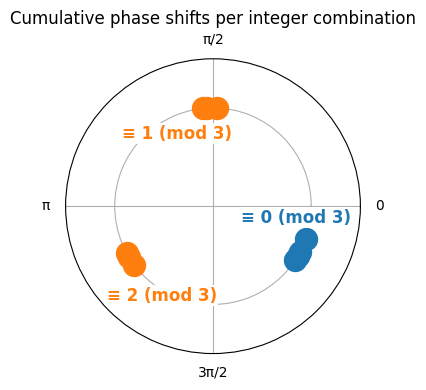

In [27]:
# Create circular plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))
theta = phase_sums_sorted
radii = jnp.ones_like(theta)

# Plot points
ax.scatter(theta[:6], radii[:6], s=250, c='tab:orange', zorder=2)
ax.scatter(theta[6:], radii[6:], s=250, c='tab:blue', zorder=2)

# Custom cluster labels (anchor theta, radius)
label_data = [
    (theta[0]+.5, 0.825, r"≡ 1 (mod 3)", 'tab:orange'),
    (theta[4]+.5, 1.05, r"≡ 2 (mod 3)", 'tab:orange'),
    (theta[-1]+.2, 0.85, r"≡ 0 (mod 3)", 'tab:blue'),
]

for angle, radius, label, color in label_data:
    ax.text(
        angle,
        radius,
        label,
        ha='center',
        va='center',
        fontsize=12,
        color=color,
        fontweight='bold',
        zorder=3,
        bbox=dict(facecolor='white', edgecolor='none', pad=1),
    )

ax.set_rmax(1.5)
ax.set_rticks([1,])
ax.set_yticklabels([])

ax.set_thetagrids([0, 90, 180, 270], ['0', 'π/2', 'π', '3π/2'])

ax.set_title("Cumulative phase shifts per integer combination")
plt.tight_layout()
plt.show()

## Summary figure v1

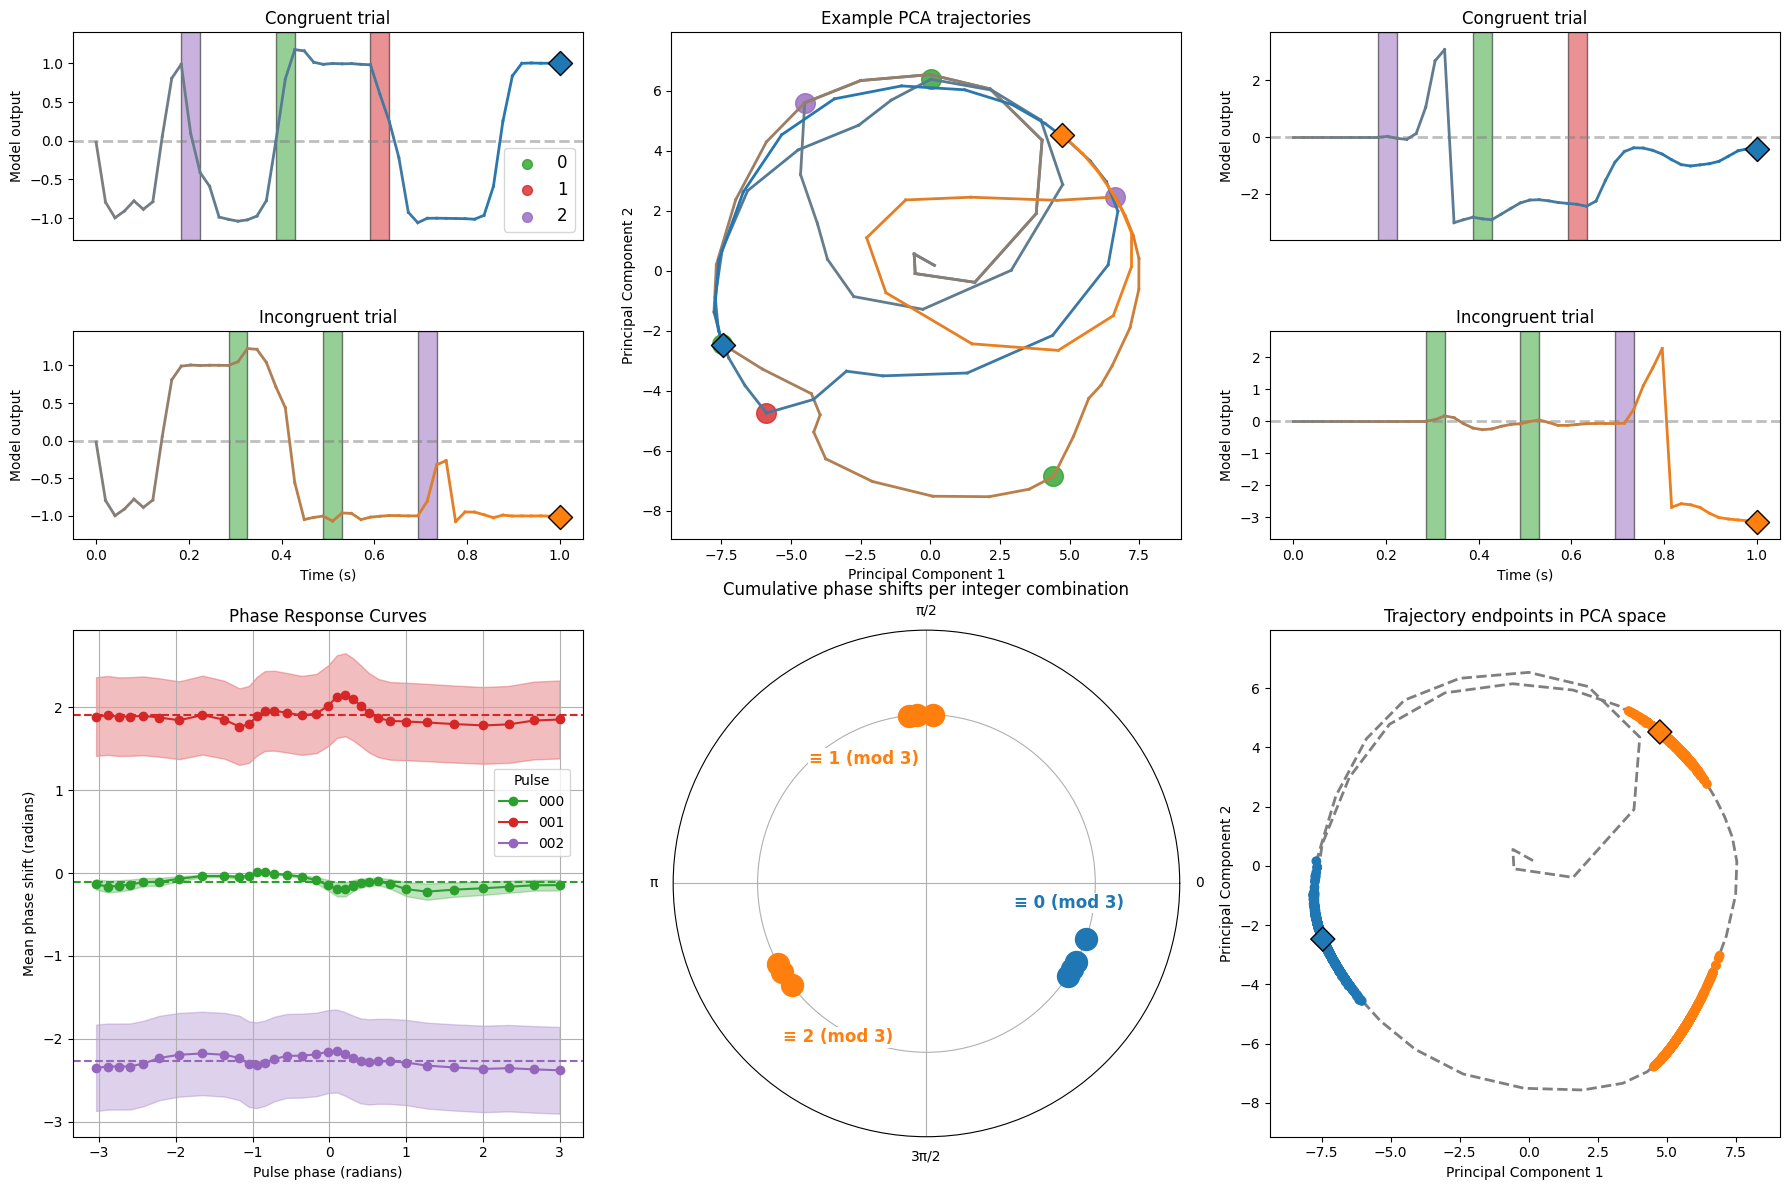

In [28]:
# Create the Figure
fig_anim = plt.figure(figsize=(18, 12))
gs = GridSpec(4, 3)

# Panel 1
ax_1 = fig_anim.add_subplot(gs[0, 0])
animator_1 = OutputAnimator(
    ax_1, output_congruent_dict, trajectory_colors,
    title='Congruent trial', stimulus_colors=stimulus_colors,
)
animator_1.color_integer_bars(decoded_congruent,)
animator_1.add_stimulus_legend()
ax_1.set_xticks([])
ax_1.set_xlabel('')
animator_1.figure()

# Panel 2
ax_2 = fig_anim.add_subplot(gs[1, 0,])
animator_2 = OutputAnimator(
    ax_2, output_incongruent_dict, trajectory_colors,
    title='Incongruent trial', stimulus_colors=stimulus_colors,
)
animator_2.color_integer_bars(decoded_incongruent,)
animator_2.figure()

# Panel 3
ax_3 = fig_anim.add_subplot(gs[:2, 1])
animator_3 = PCATrajectoryAnimator(
    ax_3, model_behavior, 1, 2, 
    trajectory_indices, trajectory_colors, 
    'Example PCA trajectories', stimulus_colors=stimulus_colors,
)
animator_3.color_integer_points(-2, decoded_congruent,)
animator_3.color_integer_points(-1, decoded_incongruent,)
animator_3.figure()

# Panel 4
ax_4 = fig_anim.add_subplot(gs[0, 2])
animator_4 = OutputAnimator(
    ax_4, phase_diff_congruent_dict, trajectory_colors,
    title='Congruent trial', stimulus_colors=stimulus_colors,
)
animator_4.color_integer_bars(decoded_congruent,)
ax_4.set_xticks([])
ax_4.set_xlabel('')
animator_4.figure()

# Panel 5
ax_5 = fig_anim.add_subplot(gs[1, 2,])
animator_5 = OutputAnimator(
    ax_5, phase_diff_incongruent_dict, trajectory_colors,
    title='Incongruent trial', stimulus_colors=stimulus_colors,
)
animator_5.color_integer_bars(decoded_incongruent,)
animator_5.figure()

# Panel 6
ax_6 = fig_anim.add_subplot(gs[2:, 0,])
for i in range(MOD):
    data = prc_tensor[i]
    mean = mean_prc_sorted[i]
    std = std_prc_sorted[i]
    color = colors[i]
    
    # Plot mean line
    ax_6.plot(pulse_phase_sorted, mean, 'o-', label=labels[i], color=color)
    
    # Plot shaded std deviation
    ax_6.fill_between(
        pulse_phase_sorted,
        mean - std,
        mean + std,
        color=color,
        alpha=0.3,
    )

    # Compute and plot constant fit (mean across phases)
    constant_fit = jnp.mean(data)
    ax_6.axhline(
        constant_fit,
        color=color,
        ls='dashed',
        lw=1.5,
    )

ax_6.set_xlabel("Pulse phase (radians)")
ax_6.set_ylabel("Mean phase shift (radians)")
ax_6.set_title("Phase Response Curves")
ax_6.legend(
    title="Pulse", 
    loc="center",
    bbox_to_anchor=(0.9, 0.64),
)
ax_6.grid(True)

# Panel 7
ax_7 = fig_anim.add_subplot(gs[2:, 1,], projection='polar')
ax_7.scatter(theta[:6], radii[:6], s=250, c='tab:orange', zorder=2)
ax_7.scatter(theta[6:], radii[6:], s=250, c='tab:blue', zorder=2)

for angle, radius, label, color in label_data:
    ax_7.text(
        angle,
        radius,
        label,
        ha='center',
        va='center',
        fontsize=12,
        color=color,
        fontweight='bold',
        zorder=3,
        bbox=dict(facecolor='white', edgecolor='none', pad=1),
    )

ax_7.set_rmax(1.5)
ax_7.set_rticks([1,])
ax_7.set_yticklabels([])
ax_7.set_thetagrids([0, 90, 180, 270], ['0', 'π/2', 'π', '3π/2'])
ax_7.set_title("Cumulative phase shifts per integer combination")

# Panel 8
ax_8 = fig_anim.add_subplot(gs[2:, 2,])
animator_8 = PCAPopulationAnimator(
    ax_8, model_behavior, 1, 2, classification_colors,
    null_trajectory=rates_pc_null, highlight_indices=trajectory_indices,
    title='Trajectory endpoints in PCA space',
)
animator_8.figure()

plt.tight_layout()
plt.show()

## Summary figure v2

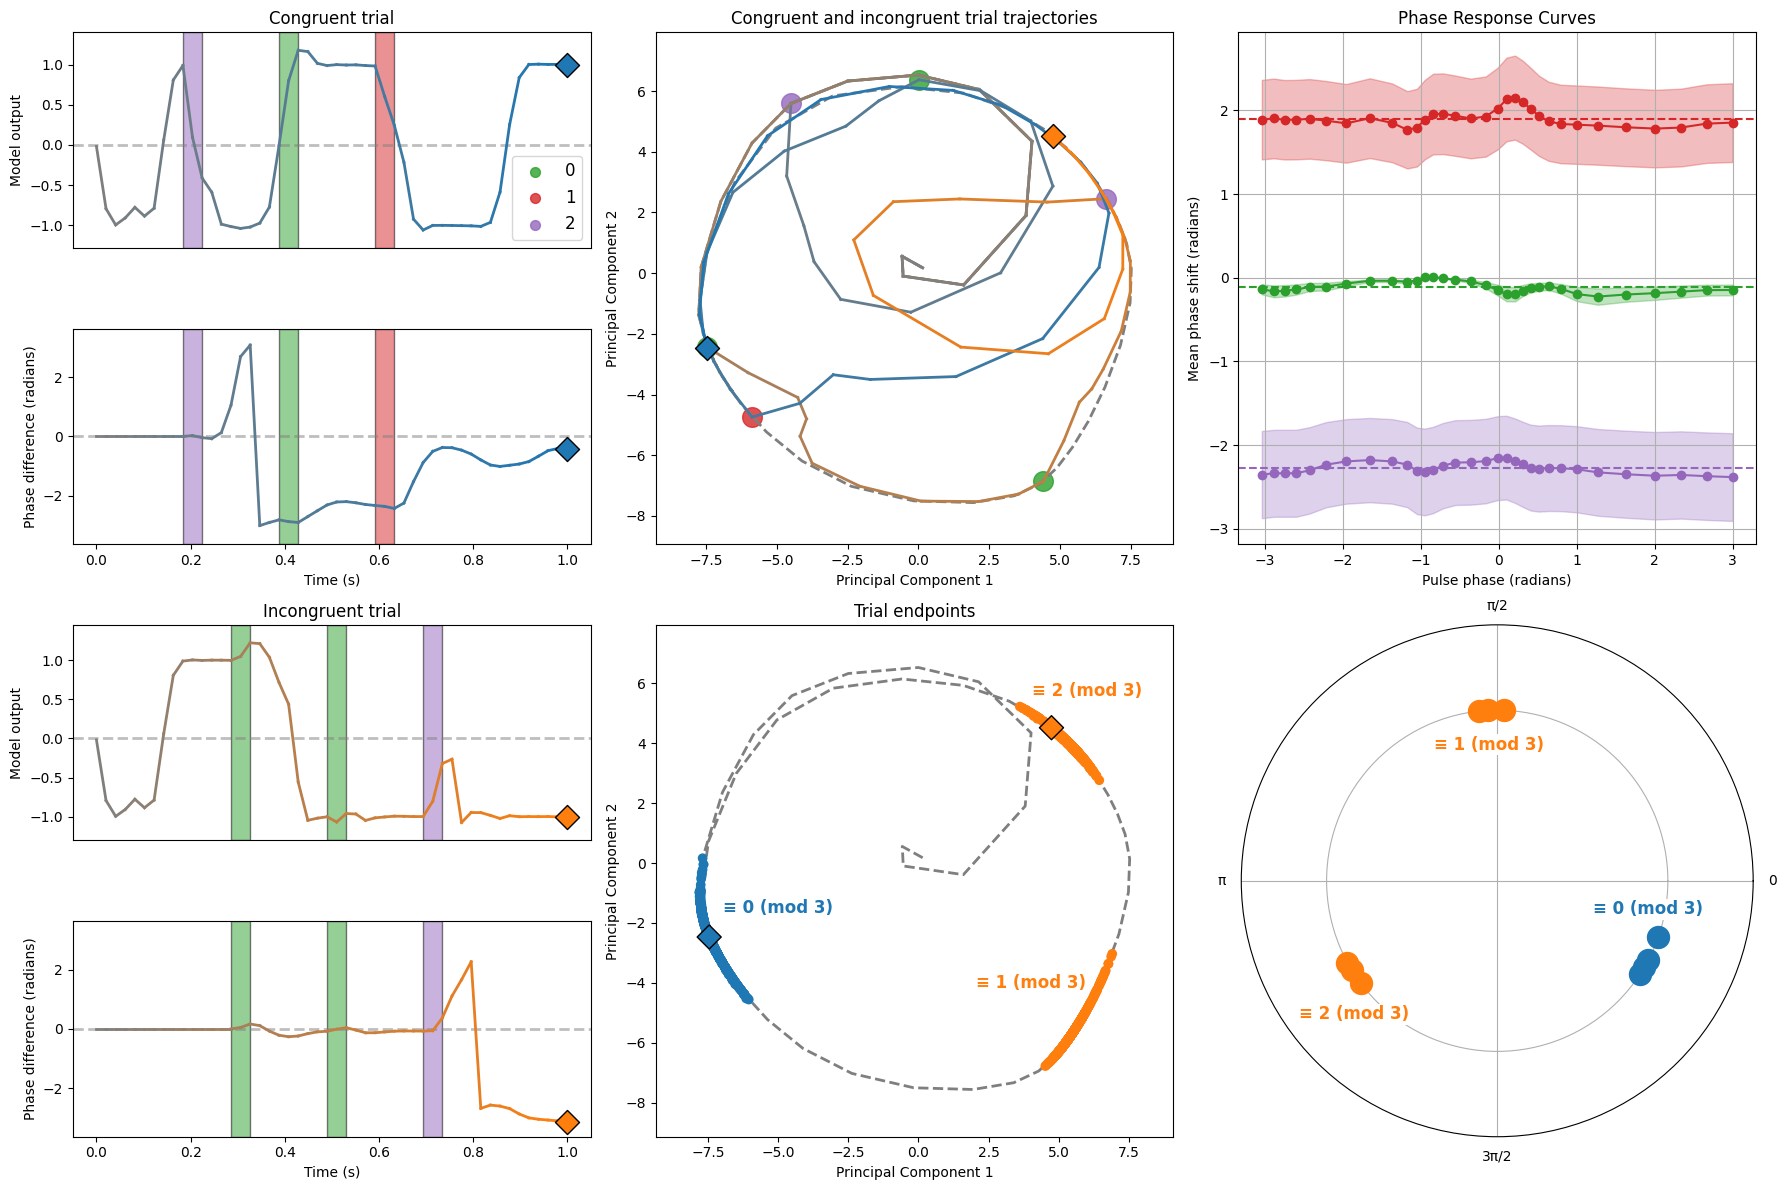

In [29]:
# Create the Figure
fig_anim = plt.figure(figsize=(18, 12))
gs = GridSpec(4, 3)

# Panel 1
ax_1 = fig_anim.add_subplot(gs[0, 0])
animator_1 = OutputAnimator(
    ax_1, output_congruent_dict, trajectory_colors,
    title='Congruent trial', stimulus_colors=stimulus_colors,
)
animator_1.color_integer_bars(decoded_congruent,)
animator_1.add_stimulus_legend()
ax_1.set_xticks([])
ax_1.set_xlabel('')
animator_1.figure()

# Panel 4
ax_4 = fig_anim.add_subplot(gs[1, 0])
animator_4 = OutputAnimator(
    ax_4, phase_diff_congruent_dict, trajectory_colors,
    title='Congruent trial', stimulus_colors=stimulus_colors,
)
animator_4.color_integer_bars(decoded_congruent,)
ax_4.set_title('')
ax_4.set_ylabel('Phase difference (radians)')
ax_4.set_ylim(bottom=-jnp.pi-0.5, top=jnp.pi+0.5)
animator_4.figure()

# Panel 2
ax_2 = fig_anim.add_subplot(gs[2, 0,])
animator_2 = OutputAnimator(
    ax_2, output_incongruent_dict, trajectory_colors,
    title='Incongruent trial', stimulus_colors=stimulus_colors,
)
animator_2.color_integer_bars(decoded_incongruent,)
ax_2.set_xticks([])
ax_2.set_xlabel('')
animator_2.figure()

# Panel 5
ax_5 = fig_anim.add_subplot(gs[3, 0,])
animator_5 = OutputAnimator(
    ax_5, phase_diff_incongruent_dict, trajectory_colors,
    title='Incongruent trial', stimulus_colors=stimulus_colors,
)
animator_5.color_integer_bars(decoded_incongruent,)
ax_5.set_title('')
ax_5.set_ylabel('Phase difference (radians)')
ax_5.set_ylim(bottom=-jnp.pi-0.5, top=jnp.pi+0.5)
animator_5.figure()

# Panel 3
ax_3 = fig_anim.add_subplot(gs[:2, 1])
animator_3 = PCATrajectoryAnimator(
    ax_3, model_behavior, 1, 2, 
    trajectory_indices, trajectory_colors, 
    'Congruent and incongruent trial trajectories', stimulus_colors=stimulus_colors,
    null_trajectory=rates_pc_null, 
)
animator_3.color_integer_points(-2, decoded_congruent,)
animator_3.color_integer_points(-1, decoded_incongruent,)
animator_3.figure()

# Panel 8
ax_8 = fig_anim.add_subplot(gs[2:, 1,])
animator_8 = PCAPopulationAnimator(
    ax_8, model_behavior, 1, 2, classification_colors,
    null_trajectory=rates_pc_null, highlight_indices=trajectory_indices,
    title='Trial endpoints',
)
animator_8.figure()

label_data = [
    (4, -4, r"≡ 1 (mod 3)", 'tab:orange'),
    (6, 5.75, r"≡ 2 (mod 3)", 'tab:orange'),
    (-5, -1.5, r"≡ 0 (mod 3)", 'tab:blue'),
]

for x_pos, y_pos, label, color in label_data:
    ax_8.text(
        x_pos,
        y_pos,
        label,
        ha='center',
        va='center',
        fontsize=12,
        color=color,
        fontweight='bold',
        zorder=3,
        bbox=dict(facecolor='white', edgecolor='none', pad=1),
    )

# Panel 6
ax_6 = fig_anim.add_subplot(gs[:2, 2,])
for i in range(MOD):
    data = prc_tensor[i]
    mean = mean_prc_sorted[i]
    std = std_prc_sorted[i]
    color = colors[i]
    
    # Plot mean line
    ax_6.plot(pulse_phase_sorted, mean, 'o-', color=color)
    
    # Plot shaded std deviation
    ax_6.fill_between(
        pulse_phase_sorted,
        mean - std,
        mean + std,
        color=color,
        alpha=0.3,
    )

    # Compute and plot constant fit (mean across phases)
    constant_fit = jnp.mean(data)
    ax_6.axhline(
        constant_fit,
        color=color,
        ls='dashed',
        lw=1.5,
    )

ax_6.set_xlabel("Pulse phase (radians)")
ax_6.set_ylabel("Mean phase shift (radians)")
ax_6.set_title("Phase Response Curves")
ax_6.grid(True)

# Panel 7
# Custom cluster labels (anchor theta, radius)
label_data = [
    (theta[0]+.1, 0.8, r"≡ 1 (mod 3)", 'tab:orange'),
    (theta[4]+.2, 1.15, r"≡ 2 (mod 3)", 'tab:orange'),
    (theta[-1]+.15, 0.9, r"≡ 0 (mod 3)", 'tab:blue'),
]

ax_7 = fig_anim.add_subplot(gs[2:, 2,], projection='polar')
ax_7.scatter(theta[:6], radii[:6], s=250, c='tab:orange', zorder=2)
ax_7.scatter(theta[6:], radii[6:], s=250, c='tab:blue', zorder=2)

for angle, radius, label, color in label_data:
    ax_7.text(
        angle,
        radius,
        label,
        ha='center',
        va='center',
        fontsize=12,
        color=color,
        fontweight='bold',
        zorder=3,
        bbox=dict(facecolor='white', edgecolor='none', pad=1),
    )

ax_7.set_rmax(1.5)
ax_7.set_rticks([1,])
ax_7.set_yticklabels([])
ax_7.set_thetagrids([0, 90, 180, 270], ['0', 'π/2', 'π', '3π/2'])

plt.tight_layout()
plt.savefig('../results/phase_code_summary_figure.png')
plt.show()

Columnar Conceptual Structure (Input ➝ Dynamics ➝ Mechanism)
- Left column = Task-level behavior (inputs, outputs, and phase differences).
- Center column = Population dynamics, with PCA trajectories and endpoint separation.
- Right column = Mechanism of computation, showing how phase coding arises.